# Title
*By: Jaeyoung Oh*

*GitHub: https://github.com/BlueJayVRStudio/DeepLearningFinal*

Lorem Ipsum Dolor...

notes though:
1. only remove outliers from training set (currently decided to use robust scaler instead of removing outliers, because we have way too many outliers, and those outliers are most likely meaningful.
2. only use interpolation on training set
3. only fit scaler on training set

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# please, no warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=ConvergenceWarning)
os.environ['PYTHONWARNINGS']='ignore'

## Iterative Data Cleaning and EDA



### Import Dataset


In [32]:
# Import datasets
df = pd.read_csv('./Data/heart_failure_clinical_records_dataset.csv')
labels = df['DEATH_EVENT']
df = df.drop(columns=['DEATH_EVENT'])

In [33]:
X_train, X_test, y_train, y_test =  train_test_split(df, labels, test_size=0.2, random_state=42)

In [34]:
print(f" train feature set size: {len(X_train)},\n test feature set size: {len(X_test)},\n train label set size: {len(y_train)},\n test label set size: {len(y_test)},\n original data frame size: {len(df)}")

 train feature set size: 239,
 test feature set size: 60,
 train label set size: 239,
 test label set size: 60,
 original data frame size: 299


### Data Description

Lorem ipsum dolor...


In [35]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 239 entries, 6 to 102
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       239 non-null    float64
 1   anaemia                   239 non-null    int64  
 2   creatinine_phosphokinase  239 non-null    int64  
 3   diabetes                  239 non-null    int64  
 4   ejection_fraction         239 non-null    int64  
 5   high_blood_pressure       239 non-null    int64  
 6   platelets                 239 non-null    float64
 7   serum_creatinine          239 non-null    float64
 8   serum_sodium              239 non-null    int64  
 9   sex                       239 non-null    int64  
 10  smoking                   239 non-null    int64  
 11  time                      239 non-null    int64  
dtypes: float64(3), int64(9)
memory usage: 24.3 KB


In [53]:
X_train.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking
6,75.000,1,246,0,15,0,127000.00,1.20,137,1,0
183,75.000,0,99,0,38,1,224000.00,2.50,134,1,0
185,60.667,1,104,1,30,0,389000.00,1.50,136,1,0
146,52.000,0,132,0,30,0,218000.00,0.70,136,1,1
30,94.000,0,582,1,38,1,263358.03,1.83,134,1,0


In [36]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 239 entries, 6 to 102
Series name: DEATH_EVENT
Non-Null Count  Dtype
--------------  -----
239 non-null    int64
dtypes: int64(1)
memory usage: 3.7 KB


### Missing Values
In our data description we saw that there were no null values. But we'll double check here.

In [37]:
# there are 96 total null values
X_train.isna().sum().sum()

0

### Data distribution and analysis on "Time" feature

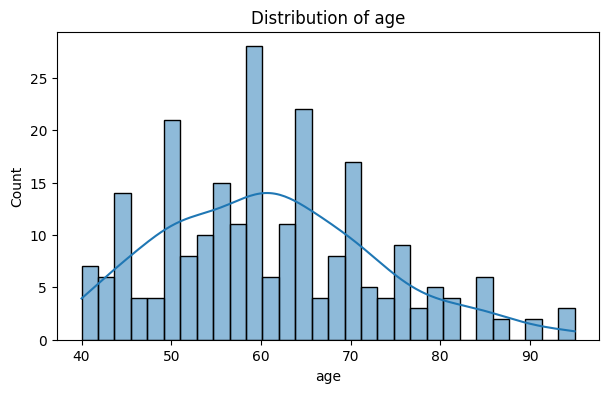

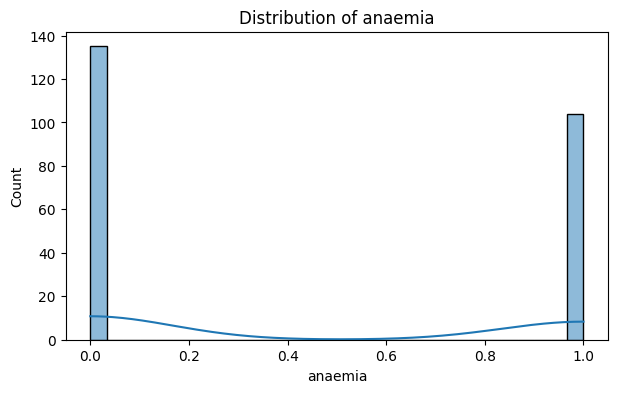

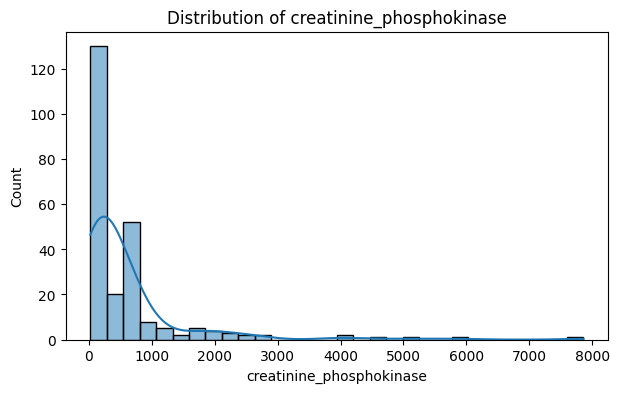

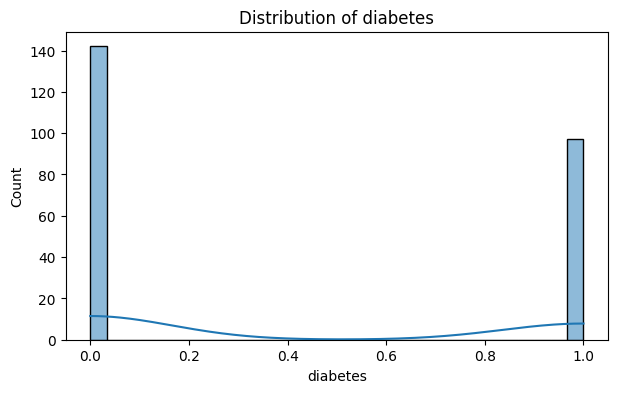

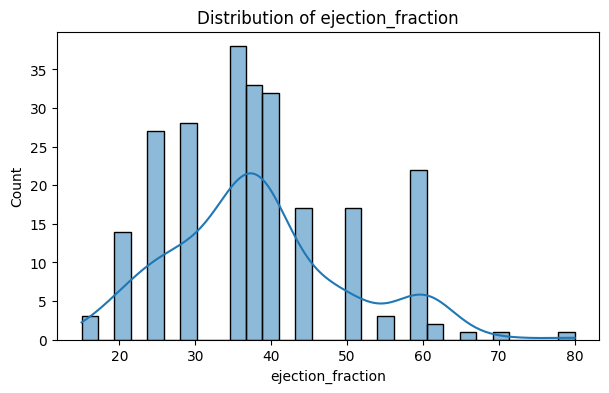

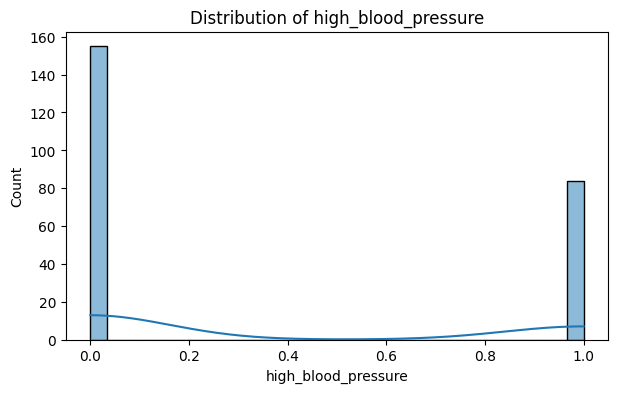

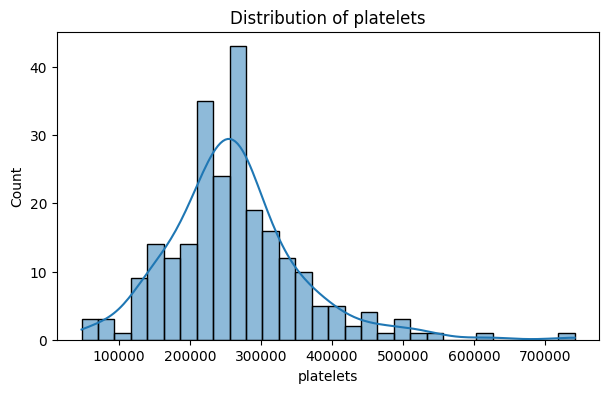

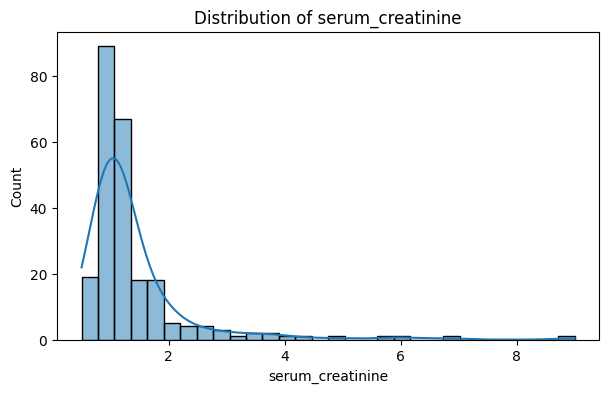

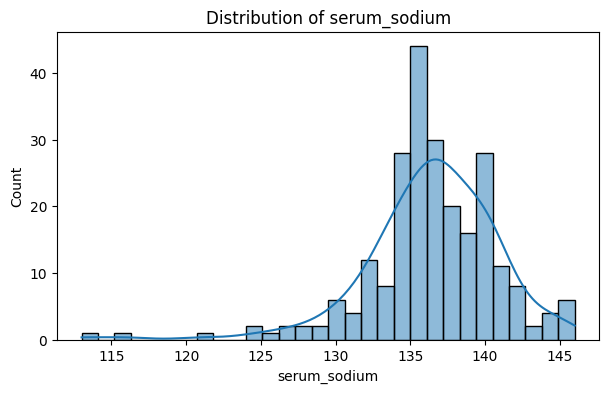

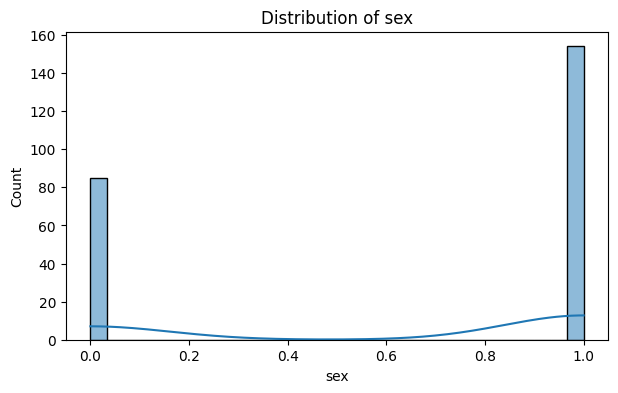

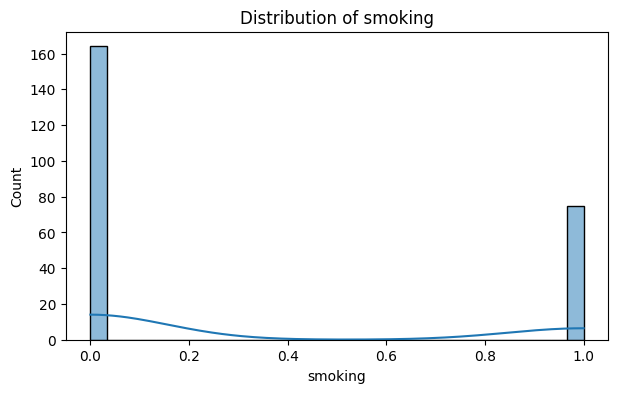

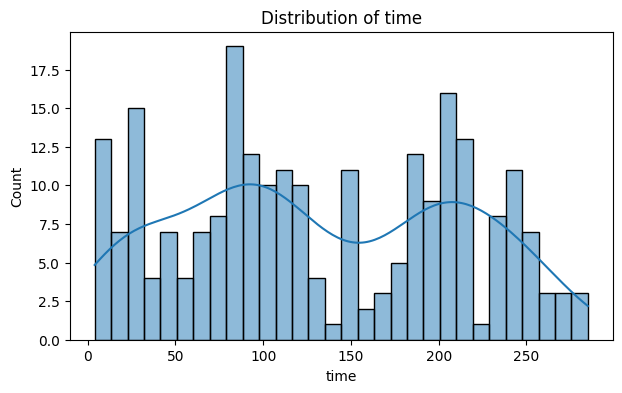

In [38]:
for col in X_train.columns:
    plt.figure(figsize=(7, 4))
    sns.histplot(X_train[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

Time could mean many different things even in medical records and unfortunately the author of this dataset has not elaborated on time. However, it's fairly reasonable to conclude that the time feature just means the time between the last follow-up exam and the heart failure event. In case the patient has passed, the time will indicate the time between the heart failure event and the death event. This is also evident in the bimodality of the time data distribution. The first peak, which has a lower mean time, correlates with the population of patients who have passed whereas the the second peak correlates with those who are still alive. Because this feature gives too strong of a predictive power, we will drop it from the dataset:

In [39]:
X_train = X_train.drop(columns=['time'])
X_test = X_test.drop(columns=['time'])

In [40]:
print(X_train.info())
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 239 entries, 6 to 102
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       239 non-null    float64
 1   anaemia                   239 non-null    int64  
 2   creatinine_phosphokinase  239 non-null    int64  
 3   diabetes                  239 non-null    int64  
 4   ejection_fraction         239 non-null    int64  
 5   high_blood_pressure       239 non-null    int64  
 6   platelets                 239 non-null    float64
 7   serum_creatinine          239 non-null    float64
 8   serum_sodium              239 non-null    int64  
 9   sex                       239 non-null    int64  
 10  smoking                   239 non-null    int64  
dtypes: float64(3), int64(8)
memory usage: 22.4 KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, 281 to 59
Data columns (total 11 columns):
 #   Column                  

### Dealing with Outliers

Below are box plots for each feature in each dataset

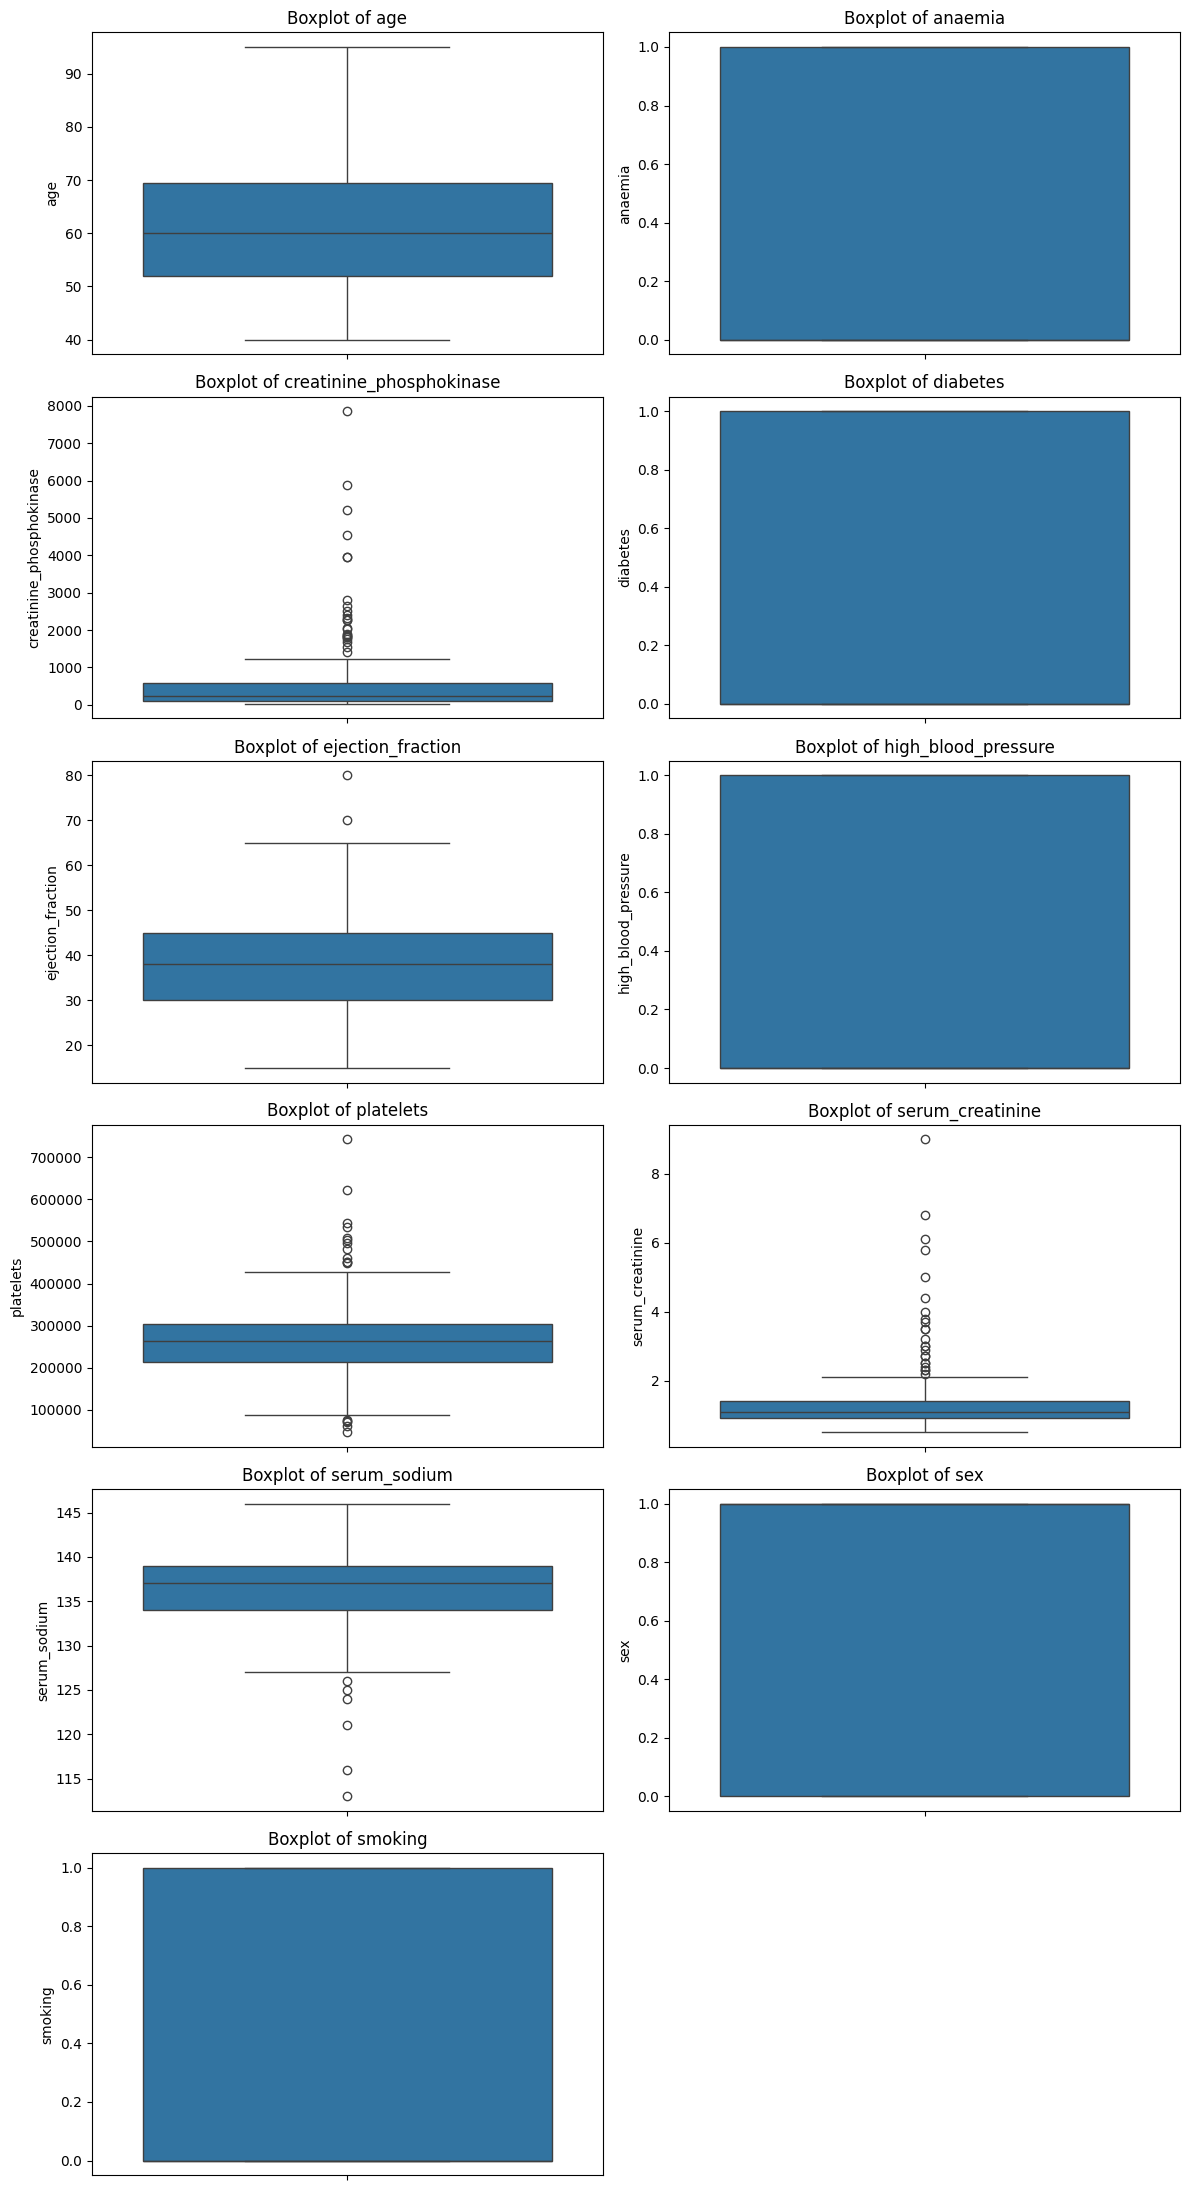

In [43]:
num_features = len(X_train.columns)

fig, axes = plt.subplots(nrows=(num_features // 2) + 1, ncols=2, figsize=(12, num_features * 2))
axes = axes.flatten()

for i, col in enumerate(X_train.columns):
    sns.boxplot(y=X_train[col], ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [44]:
Q1 = X_train['creatinine_phosphokinase'].quantile(0.25)
Q3 = X_train['creatinine_phosphokinase'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = X_train[(X_train['creatinine_phosphokinase'] < lower_bound) | (X_train['creatinine_phosphokinase'] > upper_bound)]
outliers

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking
283,65.0,0,1688,0,38,0,263358.03,1.10,138,1,1
296,45.0,0,2060,1,60,0,742000.00,0.80,138,0,0
72,85.0,0,5882,0,35,0,243000.00,1.00,132,1,1
246,55.0,0,2017,0,25,0,314000.00,1.10,138,1,0
139,50.0,0,1548,0,30,1,211000.00,0.80,138,1,0
38,60.0,0,2656,1,30,0,305000.00,2.30,137,1,0
176,69.0,0,1419,0,40,0,105000.00,1.00,135,1,1
208,60.0,1,2281,1,40,0,283000.00,1.00,141,0,0
107,45.0,1,1876,1,35,0,226000.00,0.90,138,1,0
250,50.0,0,2522,0,30,1,404000.00,0.50,139,0,0


In [45]:
print(len(outliers))

24


We have way too many outliers for such a sparse dataset. That is 10% of the dataset from creatinine phosphokinase alone. We will opt to use robust scaler. Outliers may represent critical patients, so it most likely has significant information.

### Addressing multicollinearity

Because this project is mainly concerned with classification and the algorithms we will be using are robust against collinearity, there is not much justification to do thorough analysis of multicollinearity to drop some of the features. However, because of the large number of features present in our aggregate dataset, it would be preferred to drop some of the highly correlative features.

In [46]:
X_train.corr()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking
age,1.000000,0.075484,-0.047069,-0.103526,0.020804,0.069992,0.000475,0.119166,-0.065063,0.063091,-0.032755
anaemia,0.075484,1.000000,-0.167715,-0.003595,0.028008,0.060945,-0.045011,0.018905,0.052352,-0.088370,-0.138876
creatinine_phosphokinase,-0.047069,-0.167715,1.000000,-0.063066,-0.013758,-0.120585,-0.011842,0.018959,0.079775,0.060299,0.052583
diabetes,-0.103526,-0.003595,-0.063066,1.000000,0.008377,-0.037337,0.086682,-0.043117,-0.135737,-0.169129,-0.154961
ejection_fraction,0.020804,0.028008,-0.013758,0.008377,1.000000,0.049641,0.084689,0.007005,0.170855,-0.119223,-0.078148
high_blood_pressure,0.069992,0.060945,-0.120585,-0.037337,0.049641,1.000000,0.030705,-0.039177,0.070915,-0.057220,-0.063454
platelets,0.000475,-0.045011,-0.011842,0.086682,0.084689,0.030705,1.000000,-0.069992,0.046123,-0.151702,-0.014396
serum_creatinine,0.119166,0.018905,0.018959,-0.043117,0.007005,-0.039177,-0.069992,1.000000,-0.221415,-0.041322,-0.088745
serum_sodium,-0.065063,0.052352,0.079775,-0.135737,0.170855,0.070915,0.046123,-0.221415,1.000000,-0.060037,0.013470
sex,0.063091,-0.088370,0.060299,-0.169129,-0.119223,-0.057220,-0.151702,-0.041322,-0.060037,1.000000,0.445903


<Axes: >

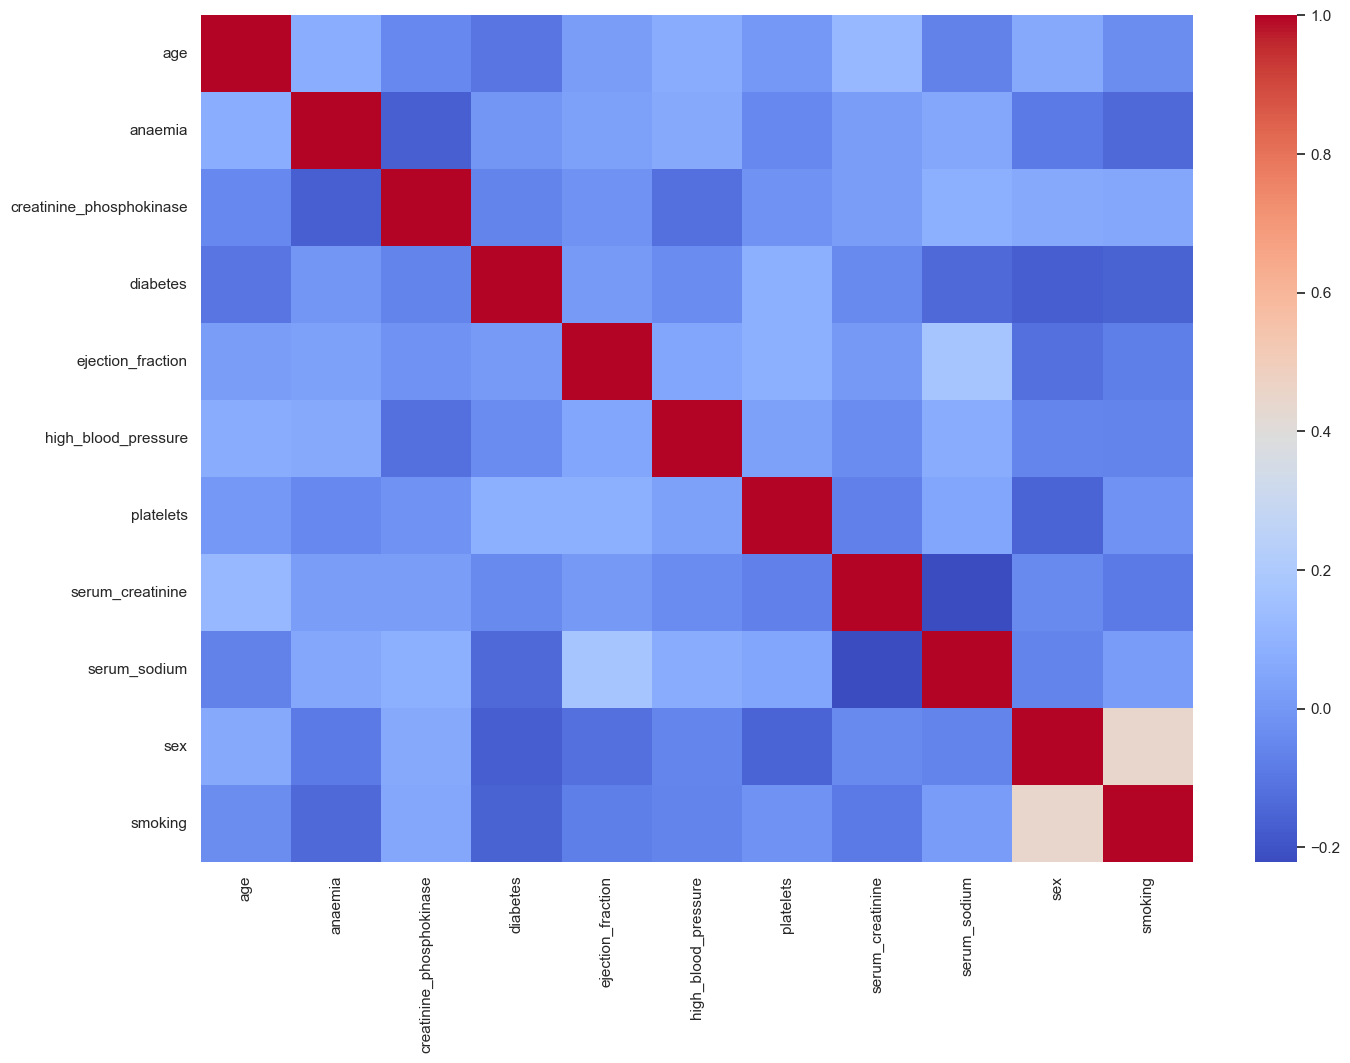

In [47]:
plt.figure(figsize=(16, 11))
sns.set(
    rc = {
        'font.size':9
    }
)
sns.heatmap(X_train.corr(), annot=False, cmap="coolwarm")

In [50]:
# We will drop features that have greater than 0.95 correlation but less than .99
# Make sure to only use train set
corr = X_train.corr().abs()

to_drop = set()

columns = corr.columns
for i in range(len(columns)):
    for j in range(i+1,len(columns)):
        if corr.iloc[i][j] > 0.95:
            to_drop.add(columns[i])
            print(corr.iloc[i][j])
            break
            
print(len(columns), len(to_drop))
print(list(to_drop))

X_train.drop(list(to_drop), axis=1, inplace=True)
X_test.drop(list(to_drop), axis=1, inplace=True)


11 0
[]


Fortunately there are no highly correlated features, meaning we will get to keep all the features that we currently have.

In [51]:
print(X_train.info())
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 239 entries, 6 to 102
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       239 non-null    float64
 1   anaemia                   239 non-null    int64  
 2   creatinine_phosphokinase  239 non-null    int64  
 3   diabetes                  239 non-null    int64  
 4   ejection_fraction         239 non-null    int64  
 5   high_blood_pressure       239 non-null    int64  
 6   platelets                 239 non-null    float64
 7   serum_creatinine          239 non-null    float64
 8   serum_sodium              239 non-null    int64  
 9   sex                       239 non-null    int64  
 10  smoking                   239 non-null    int64  
dtypes: float64(3), int64(8)
memory usage: 22.4 KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, 281 to 59
Data columns (total 11 columns):
 #   Column                  

### Checking imbalance


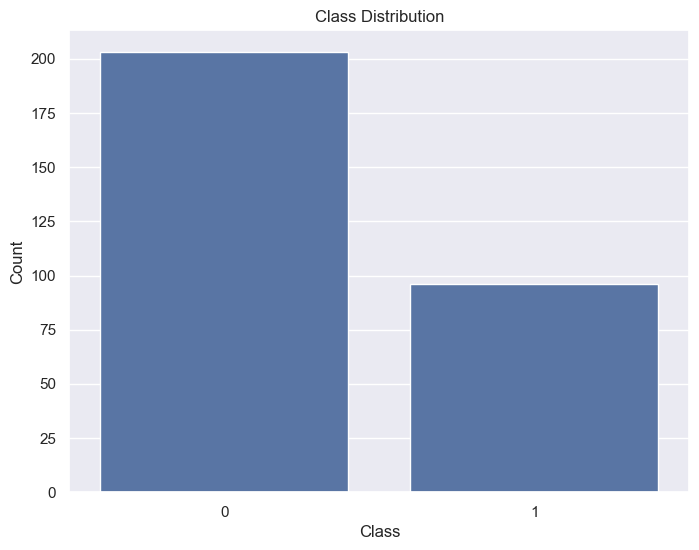

In [52]:
class_counts = labels.value_counts()

# bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

We have to use smote to interpolate data for the minority class...

### Feature Scaling

We will finalize the EDA by robust scaling. Make sure to scale both train and test but fit only on train

### Data Cleaning and EDA Conclusion

In this data cleaning and exploratory data analysis (EDA) process, we ensured consistency between the eye-tracking, ECG, and GSR datasets by confirming the correct ordering of experiments. Outliers were prevalent in many features, but instead of removing valuable data, we opted to apply robust scaling to mitigate their impact. Missing values were addressed using median imputation, ensuring no loss of data due to null values. While multicollinearity is not a major concern given the nature of the classifiers being used, we still dropped highly correlated features to simplify the model. Lastly, the target class distribution was confirmed to be balanced, allowing us to proceed without further adjustments.

This thorough cleaning and preparation have resulted in a dataset ready for further analysis and model building, with measures in place to handle outliers, missing values, and potential feature redundancy, ensuring robust model performance.

## Models

For model building, we will use logistic regression, KNN, random forest, Ada Boost with Decision Tree stumps, SVM with linear and rbf kernels, and Decision Tree classifier. As a bonus we will see how neural network performs on the dataset using MLPClassifier. For the sake of brevity, we will focus on the combined dataset with 4-Class labels, as training time and hyperparameter tuning will take significant amount of time for the listed models.

Tabbaa et al. uses 90-10 split on the dataset, and accuracy, precision and recall were measured on the validation set. The reported accuracy, precision and recall for the combined dataset were 71.88%, 76% and 72%, respectively, using support vector machine with linear kernel. Efforts will be made to improve upon these metrics using various models and tuning each model iteratively.

In [24]:
from sklearn.model_selection import train_test_split

X_train_COMBINED, X_test_COMBINED, y_train_COMBINED, y_test_COMBINED =  train_test_split(df_COMBINED, labels, test_size=0.1, random_state=42)

# We will keep track of accuracy, precision and recall of each model for summary statistics
summary_stats = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': []
}

### Linear kernel SVC

In [25]:
from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVC
from sklearn.svm import LinearSVC

parameters = {'loss': ['hinge', 'squared_hinge'],
              'C':np.logspace(-2, 0, 301, base=2)}
svc = LinearSVC(random_state=1)
grid_linsvc_COMBINED = GridSearchCV(svc, parameters, cv=10, n_jobs=-1, scoring='accuracy')

grid_linsvc_COMBINED.fit(X_train_COMBINED, y_train_COMBINED)

best_params = grid_linsvc_COMBINED.best_params_
best_score = grid_linsvc_COMBINED.best_score_

print(f"best params: {best_params}")
print(f"cross validation score: {best_score}")


best params: {'C': np.float64(0.37198937847660857), 'loss': 'hinge'}
cross validation score: 0.7107142857142857


In [26]:
from sklearn.metrics import confusion_matrix
from helpers.metrics import *

def handle_stats(predictor, model_name):
    
    # Predict validation set
    prediction = predictor.predict(X_test_COMBINED)
    test_labels = np.array(y_test_COMBINED)
    
    print(f"Prediction: {prediction} \n")
    print(f"True Label: {test_labels} \n")
    
    # Calculate Accuracy
    total = len(np.array(prediction == test_labels))
    correct = len(np.where(np.array(prediction == test_labels) == True)[0])
    accuracy = correct/total
    
    # Construct confusion matrix
    confusion_mat = confusion_matrix(test_labels, prediction)
    
    # Calculate Precision
    _precision = precision(confusion_mat)
    # Calculate Recall
    _recall = recall(confusion_mat)
    
    print(confusion_mat)
    print(f"accuracy: {accuracy}")
    print(f"precision: {_precision}")
    print(f"recall: {_recall}")
    
    # for summary statistics
    summary_stats['Model'].append(model_name)
    summary_stats['Accuracy'].append(accuracy * 100)
    summary_stats['Precision'].append(_precision * 100)
    summary_stats['Recall'].append(_recall * 100)

handle_stats(grid_linsvc_COMBINED.best_estimator_, 'Linear SVC')

Prediction: [0 1 1 1 3 3 1 1 0 3 3 0 2 1 2 1 2 3 1 0 1 1 3 0 1 0 1 2 0 3 0 3] 

True Label: [1 1 1 1 0 3 1 2 0 3 3 0 2 1 2 1 2 3 1 0 0 1 3 0 1 3 1 1 0 3 3 3] 

[[ 5  1  0  1]
 [ 1 10  1  0]
 [ 0  1  3  0]
 [ 2  0  0  7]]
accuracy: 0.78125
precision: 0.7708333333333334
recall: 0.7688492063492063


In [67]:
import time

# X_test_COMBINED.iloc[0]

x = time.perf_counter()
prediction = grid_linsvc_COMBINED.predict(np.array([X_test_COMBINED.iloc[27]]))
y = time.perf_counter()

print(len(X_test_COMBINED.iloc[27]))
print(1/(y-x))
print(np.array([X_test_COMBINED.iloc[3]]))
prediction[0]

71
520.4760466495508
[[ 0.16977182 -0.08331401 -0.31572389 -0.86663442 -0.44347432 -0.44789213
   0.1611479  -0.22320728 -0.03810894  0.15370936  0.05687606 -0.1790543
  -0.0639382   0.77878285  0.23294729 -0.0380994   0.7130807   0.04973704
   0.31987712 -0.17905431 -0.0639382   0.77878285  0.23294729 -0.29824799
  -0.06931214 -0.26653213 -0.51360252 -0.27657379  0.27422367 -0.0530674
  -0.24189398 -0.13956412  0.2190594  -0.03043368  0.51963298  0.48064236
   0.04910212  1.25089827 -0.02707283 -0.3065974  -1.11153609  0.00244557
  -1.16991859 -0.36578753  0.07603752  0.13572311  0.17097757  0.57090344
  -0.48246731  0.41036258 -0.50960401 -0.24110672 -0.32291667  0.00591133
   0.12910284 -0.01273465 -0.26578692  0.0138607   0.02960175 -0.43724275
  -0.13795379 -0.11447121  0.37622268  1.08218511 -0.6910078   0.33013825
   0.3582235   1.83893723  1.47924099 -0.06500542 -0.18561841]]


np.int64(2)

Because linear kernel only has only one hyperparameter, C, besides loss types, we can afford to have large number of steps in logspace. After much tuning, we can achieve an accuracy of 78.12%, precision of 77.08% and recall of 76.88%, which are significantly higher than the reported metrics by Tabbaa et al. It must be noted, however, that these values vary highly upon the random state of the dataset split, but the resulting accuracies are generally higher than the reported accuracy in the paper. 

### RBF kernel SVC

In [248]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
# from sklearn.svm import LinearSVC

parameters = {'kernel': ['rbf'],
              'C':np.logspace(-1, 30, 41, base=2),
              'gamma':np.logspace(-30, -1, 41, base=2)
             }
svc = SVC(random_state=0)
grid_svc_COMBINED = GridSearchCV(svc, parameters, cv=10, n_jobs=-1, scoring='accuracy')

grid_svc_COMBINED.fit(X_train_COMBINED, y_train_COMBINED)

best_params = grid_svc_COMBINED.best_params_
best_score = grid_svc_COMBINED.best_score_


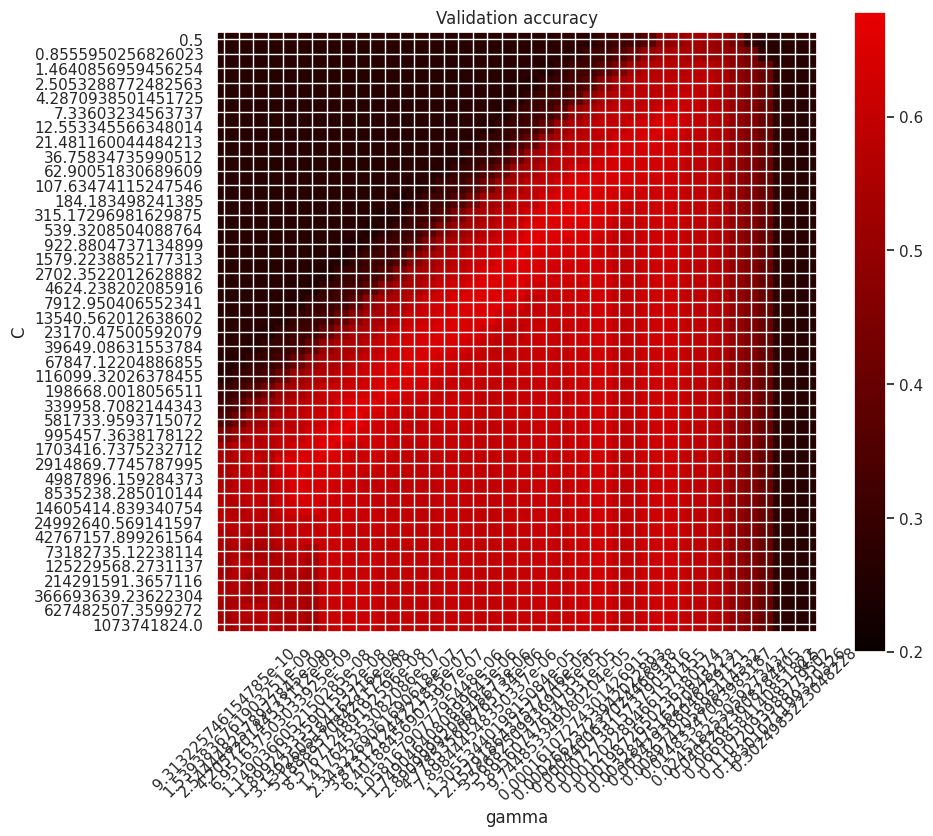

In [249]:
from helpers.metrics import *

plotSearchGrid(grid_svc_COMBINED)

Gamma vs C curve shows that the current tuning with rbf kernel is optimized. It achieves a far lower metrics than linear kernel.

In [250]:
print(f"best params: {best_params}")
print(f"cross validation score: {best_score} \n")
handle_stats(grid_svc_COMBINED.best_estimator_, 'RBF SVC')

best params: {'C': np.float64(581733.9593715072), 'gamma': np.float64(8.576712489192596e-08), 'kernel': 'rbf'}
cross validation score: 0.6785714285714286 

Prediction: [0 2 1 1 0 0 1 1 0 3 3 0 2 1 0 0 2 3 1 0 1 1 3 0 2 3 1 2 0 3 0 2] 

True Label: [1 1 1 1 0 3 1 2 0 3 3 0 2 1 2 1 2 3 1 0 0 1 3 0 1 3 1 1 0 3 3 3] 

[[6 1 0 0]
 [2 7 3 0]
 [1 1 2 0]
 [2 0 1 6]]
accuracy: 0.65625
precision: 0.6641414141414141
recall: 0.6517857142857143


### Logistic Regression

In [251]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=1)

param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': np.logspace(-10, 10, 11, base=2),
    'solver': ['liblinear', 'saga', 'lbfgs'],
    'max_iter': [10, 13, 15, 17, 20],
    'class_weight': [None, 'balanced'],
    'l1_ratio': [0, 0.1, 0.5, 0.9, 1],
}

grid_logistic_COMBINED = GridSearchCV(estimator=logreg, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1, verbose=0)

grid_logistic_COMBINED.fit(X_train_COMBINED, y_train_COMBINED)

best_params = grid_logistic_COMBINED.best_params_
best_score = grid_logistic_COMBINED.best_score_

print(f"best params: {best_params}")
print(f"cross validation score: {best_score} \n")
handle_stats(grid_logistic_COMBINED.best_estimator_, 'Logistic Regression')

best params: {'C': np.float64(4.0), 'class_weight': 'balanced', 'l1_ratio': 0, 'max_iter': 10, 'penalty': 'l1', 'solver': 'liblinear'}
cross validation score: 0.7035714285714285 

Prediction: [1 1 1 1 3 0 1 1 0 3 3 0 2 1 2 1 2 3 2 0 1 1 3 0 1 3 0 1 0 3 0 3] 

True Label: [1 1 1 1 0 3 1 2 0 3 3 0 2 1 2 1 2 3 1 0 0 1 3 0 1 3 1 1 0 3 3 3] 

[[ 5  1  0  1]
 [ 1 10  1  0]
 [ 0  1  3  0]
 [ 2  0  0  7]]
accuracy: 0.78125
precision: 0.7708333333333334
recall: 0.7688492063492063


Logistic regression yields same exact results as Linear SVC, which may not be too abnormal since they are both linear models. Even though logistic regression are more sensitive to outliers, the features were scaled with robust scaling, which is yet another confirmation of their equivalent performance.

### K Nearest Neighbor

In [259]:
from sklearn.preprocessing import StandardScaler

class PCA:
    def __init__(self, target_explained_variance=None):
        """
        explained_variance: float, the target level of explained variance
        """
        self.target_explained_variance = target_explained_variance
        self.feature_size = -1

    def standardize(self, X):
        """
        standardize features using standard scaler
        :param X: input data with shape m (# of observations) X n (# of features)
        :return: standardized features (Hint: use skleanr's StandardScaler. Import any library as needed)
        """
        # your code here
        scaler = StandardScaler()
        return scaler.fit_transform(X)

    def compute_mean_vector(self, X_std):
        """
        compute mean vector
        :param X_std: transformed data
        :return n X 1 matrix: mean vector
        """
        # your code here
        return np.array(np.mean(X_std, axis=0))

    def compute_cov(self, X_std, mean_vec):
        """
        Covariance using mean, (don't use any numpy.cov)
        :param X_std:
        :param mean_vec:
        :return n X n matrix:: covariance matrix
        """
        # your code here
        X_centered = X_std - mean_vec
        cov = (X_centered.T @ X_centered) / (len(X_std) - 1)
        return cov

    def compute_eigen_vector(self, cov_mat):
        """
        Eigenvector and eigen values using numpy. Uses numpy's eigenvalue function
        :param cov_mat:
        :return: (eigen_values, eigen_vector)
        """
        # your code here
        eigenvalues, eigenvectors = np.linalg.eig(cov_mat)
        
        return eigenvalues, eigenvectors

    def compute_explained_variance(self, eigen_vals):
        """
        sort eigen values and compute explained variance.
        explained variance informs the amount of information (variance)
        can be attributed to each of  the principal components.
        :param eigen_vals:
        :return: explained variance.
        """
        # your code here
        sorted_eigen_vals = np.sort(eigen_vals)[::-1]
        total_variance = np.sum(sorted_eigen_vals)
        explained_variance = [(val / total_variance) for val in sorted_eigen_vals]
        
        return explained_variance

    def cumulative_sum(self, var_exp):
        """
        return cumulative sum of explained variance.
        :param var_exp: explained variance
        :return: cumulative explained variance
        """
        return np.cumsum(var_exp)

    def compute_weight_matrix(self, eig_pairs, cum_var_exp):
        """
        compute weight matrix of top principal components conditioned on target
        explained variance.
        (Hint : use cumilative explained variance and target_explained_variance to find
        top components)
        
        :param eig_pairs: list of tuples containing eigenvalues and eigenvectors, 
        sorted by eigenvalues in descending order (the biggest eigenvalue and corresponding eigenvectors first).
        :param cum_var_exp: cumulative expalined variance by features
        :return: weight matrix (the shape of the weight matrix is n X k)
        """
        # your code here
        num_components = 0
        for i, cum_var in enumerate(cum_var_exp):
            if cum_var >= self.target_explained_variance:
                num_components = i
                break
        
        selected_eigenvectors = [eig_pairs[i][1] for i in range(num_components)]
        weight_matrix = np.column_stack(selected_eigenvectors)
        
        return weight_matrix

    def transform_data(self, X_std, matrix_w):
        """
        transform data to subspace using weight matrix
        :param X_std: standardized data
        :param matrix_w: weight matrix
        :return: data in the subspace
        """
        return X_std.dot(matrix_w)

    def fit(self, X):
        """    
        entry point to the transform data to k dimensions
        standardize and compute weight matrix to transform data.
        The fit functioin returns the transformed features. k is the number of features which cumulative 
        explained variance ratio meets the target_explained_variance.
        :param   m X n dimension: train samples
        :return  m X k dimension: subspace data. 
        """
    
        self.feature_size = X.shape[1]
        
        # your code here
        
        X_std = self.standardize(X)
        mean_vec = self.compute_mean_vector(X_std)
        cov_mat = self.compute_cov(X_std, mean_vec)
        
        eigenvalues, eigenvectors = self.compute_eigen_vector(cov_mat)
        
        explained_variance = self.compute_explained_variance(eigenvalues)
        cum_var_exp = self.cumulative_sum(explained_variance)
        
        eig_pairs = [(eigenvalues[i], eigenvectors[:, i]) for i in range(len(eigenvalues))]
        eig_pairs.sort(key=lambda x: x[0], reverse=True)
        
        matrix_w = self.compute_weight_matrix(eig_pairs, cum_var_exp)
        
        print(len(matrix_w),len(matrix_w[0]))
        return self.transform_data(X_std=X_std, matrix_w=matrix_w)


In [260]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA as pca1

X = X_train_COMBINED
pca_handler = PCA(target_explained_variance=0.9)

cov_mat = pca_handler.compute_cov(X, pca_handler.compute_mean_vector(X))

print(np.array(cov_mat))


(280, 71)
(280, 71)
hello world
[[ 0.52010952 -1.21501257 -0.83255381 ... -0.02556815 -0.03395699
  -0.02901466]
 [-1.21501257  7.97315121  3.97332534 ... -0.10887816 -0.12259777
  -0.13588416]
 [-0.83255381  3.97332534  2.52252384 ... -0.03832026 -0.0311357
  -0.05466297]
 ...
 [-0.02556815 -0.10887816 -0.03832026 ...  0.71901577  0.20742253
   0.23723399]
 [-0.03395699 -0.12259777 -0.0311357  ...  0.20742253  0.53491945
   0.52545968]
 [-0.02901466 -0.13588416 -0.05466297 ...  0.23723399  0.52545968
   0.77514569]]


In [261]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA as pca1

accuracies = []
precisions = []
recalls = []

for i in range(1, 30):
    scaling=StandardScaler()
 
    scaling.fit(X_train_COMBINED)
    scaled_data=scaling.transform(X_train_COMBINED)

    pca_sk = pca1(n_components=.8).fit(scaled_data)
    X_train_REDUCED = pca_sk.transform(scaled_data)
    # X_test_REDUCED = pca.transform(X_test_COMBINED)

    pca_handler = PCA(target_explained_variance=0.8)
    X_train_REDUCED_1 = pca_handler.fit(scaled_data)

    print(pca_sk.get_covariance())
    print(pca_handler.cov_mat)
    
    # print(X_train_REDUCED[0])
    # print(X_train_REDUCED_1[0])
    break
    
    param_grid = {
        'n_neighbors': [1, 3, 5, 7, 10, 13, 15, 17, 19, 21],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'leaf_size': [0, 1, 2, 3, 4, 5, 10],
        'metric': ['euclidean', 'manhattan', 'chebyshev'],
        'p': [1, 2]
    }
    
    knn = KNeighborsClassifier()
    
    grid_knn_COMBINED = GridSearchCV(estimator=knn, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0)
    grid_knn_COMBINED.fit(X_train_REDUCED, y_train_COMBINED)
    
    best_params = grid_knn_COMBINED.best_params_
    best_score = grid_knn_COMBINED.best_score_
    
    print(f"best params: {best_params}")
    print(f"cross validation score: {best_score} \n")
    
    # Predict validation set
    prediction = grid_knn_COMBINED.predict(X_test_REDUCED)
    test_labels = np.array(y_test_COMBINED)
    
    print(f"Prediction: {prediction} \n")
    print(f"True Label: {test_labels} \n")
    
    # Calculate Accuracy
    total = len(np.array(prediction == test_labels))
    correct = len(np.where(np.array(prediction == test_labels) == True)[0])
    accuracy = correct/total
    
    # Construct confusion matrix
    confusion_mat = confusion_matrix(test_labels, prediction)
    
    # Calculate Precision
    _precision = precision(confusion_mat)
    # Calculate Recall
    _recall = recall(confusion_mat)
    
    # print(confusion_mat)
    # print(f"accuracy: {accuracy}")
    # print(f"precision: {_precision}")
    # print(f"recall: {_recall}")
    accuracies.append(accuracy)
    precisions.append(_precision)
    recalls.append(_recall)

# fig, ax = plt.subplots()
# ax.set_xlabel("features")
# ax.set_ylabel("score")
# ax.set_title("scores vs features")
# ax.plot(accuracies, label="recall", drawstyle="steps-post")
# ax.plot(precisions, label="accuracy", drawstyle="steps-post")
# ax.plot(recalls, label="recall", drawstyle="steps-post")
# ax.legend()
# plt.show() 


# handle_stats(grid_knn_COMBINED.best_estimator_, 'KNN')

(280, 71)
(280, 71)
hello world
71 19
[[ 1.07744227 -0.65066511 -0.74994039 ... -0.05321861 -0.06337998
  -0.05769102]
 [-0.65066511  0.98476642  0.74587322 ... -0.07483754 -0.07426625
  -0.05961628]
 [-0.74994039  0.74587322  1.10781188 ... -0.03786443 -0.04539399
  -0.04981574]
 ...
 [-0.05321861 -0.07483754 -0.03786443 ...  1.10335875  0.34269096
   0.34377525]
 [-0.06337998 -0.07426625 -0.04539399 ...  0.34269096  1.00072182
   0.72594074]
 [-0.05769102 -0.05961628 -0.04981574 ...  0.34377525  0.72594074
   1.03638784]]
[[ 1.         -0.59664825 -0.72685414 ... -0.04181025 -0.06437802
  -0.04569603]
 [-0.59664825  1.          0.88597504 ... -0.04547331 -0.05936403
  -0.05465906]
 [-0.72685414  0.88597504  1.         ... -0.02845389 -0.02680383
  -0.03909165]
 ...
 [-0.04181025 -0.04547331 -0.02845389 ...  1.          0.33445872
   0.3177723 ]
 [-0.06437802 -0.05936403 -0.02680383 ...  0.33445872  1.
   0.81602514]
 [-0.04569603 -0.05465906 -0.03909165 ...  0.3177723   0.81602514
  

KNN suffers from the Curse of Dimensionality. Since our dataset has large number of features, KNN may not perform well.

### Random Forest Classifier

In [267]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf_train_scores = []
rf_test_scores = []

for i in range(1,51):
    rf = RandomForestClassifier(n_estimators=i, random_state=0)
    rf.fit(X_train_COMBINED, y_train_COMBINED)
    #
    prediction = rf.predict(X_train_COMBINED)
    test_labels = np.array(y_train_COMBINED)
    
    total = len(np.array(prediction == test_labels))
    correct = len(np.where(np.array(prediction == test_labels) == True)[0])
    rf_train_scores.append(correct/total)
    ##
    prediction = rf.predict(X_test_COMBINED)
    test_labels = np.array(y_test_COMBINED)
    
    total = len(np.array(prediction == test_labels))
    correct = len(np.where(np.array(prediction == test_labels) == True)[0])
    rf_test_scores.append(correct/total)
    
# print(rf_train_scores)
# print(rf_test_scores)

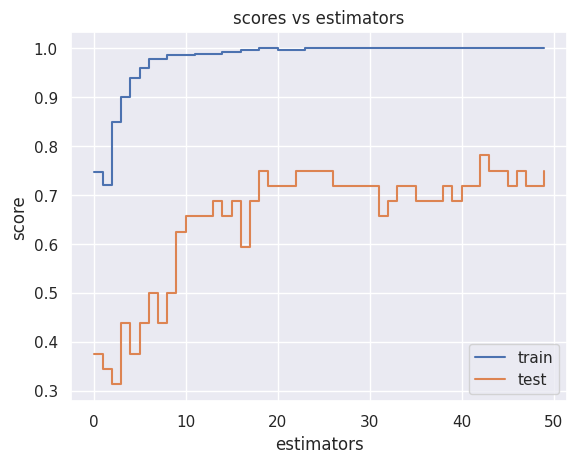

In [268]:
fig, ax = plt.subplots()
ax.set_xlabel("estimators")
ax.set_ylabel("score")
ax.set_title("scores vs estimators")
ax.plot(rf_train_scores, label="train", drawstyle="steps-post")
ax.plot(rf_test_scores, label="test", drawstyle="steps-post")
ax.legend()
plt.show() 


In [255]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': np.arange(15, 30),
    'max_depth': [None, 1, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

rf = RandomForestClassifier(random_state=0)
grid_rf_COMBINED = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, n_jobs=-1, verbose=0)
grid_rf_COMBINED.fit(X_train_COMBINED, y_train_COMBINED)

best_params = grid_rf_COMBINED.best_params_
best_score = grid_rf_COMBINED.best_score_

print(f"best params: {best_params}")
print(f"cross validation score: {best_score} \n")
handle_stats(grid_rf_COMBINED.best_estimator_, 'Random Forest')

best params: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': np.int64(29)}
cross validation score: 0.6714285714285715 

Prediction: [1 1 0 1 3 3 1 1 0 3 3 1 2 1 2 0 2 3 1 0 1 1 3 3 2 3 1 1 0 3 0 0] 

True Label: [1 1 1 1 0 3 1 2 0 3 3 0 2 1 2 1 2 3 1 0 0 1 3 0 1 3 1 1 0 3 3 3] 

[[3 2 0 2]
 [2 9 1 0]
 [0 1 3 0]
 [2 0 0 7]]
accuracy: 0.6875
precision: 0.6765873015873016
recall: 0.6765873015873016


### AdaBoost Classifier

In [256]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada = AdaBoostClassifier(n_estimators=2500, random_state=0, estimator=DecisionTreeClassifier(max_depth=1, random_state=0))
ada.fit(X_train_COMBINED, y_train_COMBINED)
staged_scores_train = list(ada.staged_score(X_train_COMBINED, y_train_COMBINED))
staged_scores_test = list(ada.staged_score(X_test_COMBINED, y_test_COMBINED))

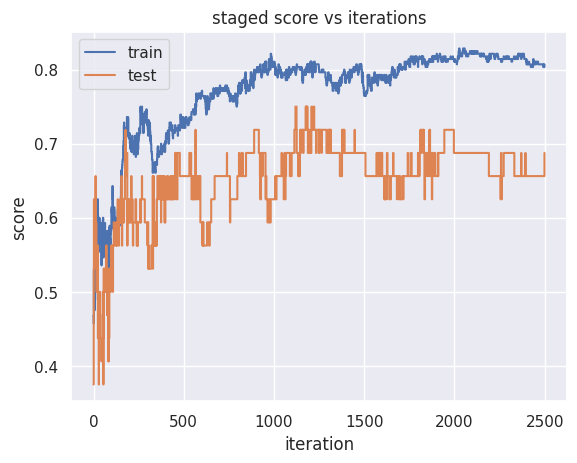

In [257]:
fig, ax = plt.subplots()
ax.set_xlabel("iteration")
ax.set_ylabel("score")
ax.set_title("staged score vs iterations")
ax.plot(staged_scores_train, label="train", drawstyle="steps-post")
ax.plot(staged_scores_test, label="test", drawstyle="steps-post")
ax.legend()
plt.show() 


In [258]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Grid search is not entirely appropriate for AdaBoost.  First try optimizing with staged scores.
# Use grid search only for cross validation 

parameters = {
    'n_estimators': [1000],
    'learning_rate': np.logspace(-10, 10, 11, base=2)
}

ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1, random_state=0), random_state=0)

grid_ada_COMBINED = GridSearchCV(ada, parameters, cv=10, scoring='accuracy', verbose=0)

grid_ada_COMBINED.fit(X_train_COMBINED, y_train_COMBINED)

best_params = grid_ada_COMBINED.best_params_
best_score = grid_ada_COMBINED.best_score_

print(f"best params: {best_params}")
print(f"cross validation score: {best_score} \n")
handle_stats(grid_ada_COMBINED.best_estimator_, 'Ada Boost')

best params: {'learning_rate': np.float64(0.0009765625), 'n_estimators': 1000}
cross validation score: 0.5928571428571429 

Prediction: [1 1 1 1 3 3 1 1 3 3 3 1 2 1 2 1 1 3 1 0 1 1 3 3 1 3 1 1 2 3 1 3] 

True Label: [1 1 1 1 0 3 1 2 0 3 3 0 2 1 2 1 2 3 1 0 0 1 3 0 1 3 1 1 0 3 3 3] 

[[ 1  2  1  3]
 [ 0 12  0  0]
 [ 0  2  2  0]
 [ 0  1  0  8]]
accuracy: 0.71875
precision: 0.7749554367201426
recall: 0.6329365079365079


### Decision Tree Classifier

In [259]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 1, 5, 10, 20, 50, 100],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'splitter': ['best', 'random']
}

dt = DecisionTreeClassifier(random_state=0)

grid_dt_COMBINED = GridSearchCV(estimator=dt, param_grid=param_grid, cv=10, n_jobs=-1, verbose=0)

grid_dt_COMBINED.fit(X_train_COMBINED, y_train_COMBINED)

best_params = grid_dt_COMBINED.best_params_
best_score = grid_dt_COMBINED.best_score_

print(f"best params: {best_params}")
print(f"cross validation score: {best_score} \n")
handle_stats(grid_dt_COMBINED, 'Decision Tree')

best params: {'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
cross validation score: 0.5678571428571428 

Prediction: [1 1 1 1 3 3 1 1 0 3 3 2 0 1 1 1 0 2 1 0 1 0 3 0 2 3 1 1 0 3 1 3] 

True Label: [1 1 1 1 0 3 1 2 0 3 3 0 2 1 2 1 2 3 1 0 0 1 3 0 1 3 1 1 0 3 3 3] 

[[ 4  1  1  1]
 [ 1 10  1  0]
 [ 2  2  0  0]
 [ 0  1  1  7]]
accuracy: 0.65625
precision: 0.5401785714285714
recall: 0.5456349206349206


### Neural Network: MLP Classifier

In [68]:
# Bonus: NN
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import warnings
from sklearn.exceptions import ConvergenceWarning

mlp = MLPClassifier(max_iter=1000, random_state=0, verbose=False)

param_grid = {
    'hidden_layer_sizes': [(80, 80), (80, 80, 20)],  
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],  
    'alpha': [0.0001, 0.001, 0.01],  
    'learning_rate': ['constant', 'adaptive'],  
    'learning_rate_init': [0.001, 0.01, 0.1],  
    'batch_size': ['auto', 64, 128], 
}

grid_mlp_COMBINED = GridSearchCV(mlp, param_grid, cv=5, n_jobs=-1, verbose=0)

grid_mlp_COMBINED.fit(X_train_COMBINED, y_train_COMBINED)

best_params = grid_mlp_COMBINED.best_params_
best_score = grid_mlp_COMBINED.best_score_

print(f"best params: {best_params}")
print(f"cross validation score: {best_score} \n")
handle_stats(grid_mlp_COMBINED.best_estimator_, 'MLP Classifier (NN)')

best params: {'activation': 'tanh', 'alpha': 0.0001, 'batch_size': 128, 'hidden_layer_sizes': (80, 80), 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'solver': 'adam'}
cross validation score: 0.6571428571428573 

Prediction: [0 2 1 1 0 3 1 1 1 3 3 0 2 1 2 1 2 3 2 0 0 1 3 0 2 3 1 1 0 3 0 3] 

True Label: [1 1 1 1 0 3 1 2 0 3 3 0 2 1 2 1 2 3 1 0 0 1 3 0 1 3 1 1 0 3 3 3] 

[[6 1 0 0]
 [1 8 3 0]
 [0 1 3 0]
 [1 0 0 8]]
accuracy: 0.78125
precision: 0.7625
recall: 0.7906746031746031


In [74]:
import time

# X_test_COMBINED.iloc[0]

x = time.perf_counter()
prediction = grid_mlp_COMBINED.predict(np.array([X_test_COMBINED.iloc[27]]))
y = time.perf_counter()

print(len(X_test_COMBINED))
print((y-x), 1/(y-x))
print(np.array([X_test_COMBINED.iloc[3]]))
prediction[0]

71
0.0027267350087640807 366.73897418922996
[[ 0.16977182 -0.08331401 -0.31572389 -0.86663442 -0.44347432 -0.44789213
   0.1611479  -0.22320728 -0.03810894  0.15370936  0.05687606 -0.1790543
  -0.0639382   0.77878285  0.23294729 -0.0380994   0.7130807   0.04973704
   0.31987712 -0.17905431 -0.0639382   0.77878285  0.23294729 -0.29824799
  -0.06931214 -0.26653213 -0.51360252 -0.27657379  0.27422367 -0.0530674
  -0.24189398 -0.13956412  0.2190594  -0.03043368  0.51963298  0.48064236
   0.04910212  1.25089827 -0.02707283 -0.3065974  -1.11153609  0.00244557
  -1.16991859 -0.36578753  0.07603752  0.13572311  0.17097757  0.57090344
  -0.48246731  0.41036258 -0.50960401 -0.24110672 -0.32291667  0.00591133
   0.12910284 -0.01273465 -0.26578692  0.0138607   0.02960175 -0.43724275
  -0.13795379 -0.11447121  0.37622268  1.08218511 -0.6910078   0.33013825
   0.3582235   1.83893723  1.47924099 -0.06500542 -0.18561841]]


np.int64(1)

### Ensemble Voting

In [261]:
# Ensemble Voting
from scipy import stats

class EnsemblePredictor:
    def __init__(self, predictors):
        self.predictors = predictors
        
    def predict(self, test_data):
        predictions = np.array([i.predict(test_data) for i in self.predictors])
        prediction = stats.mode(predictions, axis=0)[0]
        return prediction

# takes in models
ensemble_predictor = EnsemblePredictor([grid_linsvc_COMBINED.best_estimator_, grid_svc_COMBINED.best_estimator_, 
                                        grid_logistic_COMBINED.best_estimator_, grid_rf_COMBINED.best_estimator_,
                                        grid_knn_COMBINED.best_estimator_, grid_ada_COMBINED.best_estimator_, 
                                        grid_dt_COMBINED.best_estimator_, grid_mlp_COMBINED.best_estimator_])

handle_stats(ensemble_predictor, 'Ensemble Voting')

Prediction: [1 1 1 1 3 3 1 1 0 3 3 0 2 1 2 1 2 3 1 0 1 1 3 0 1 3 1 1 0 3 0 3] 

True Label: [1 1 1 1 0 3 1 2 0 3 3 0 2 1 2 1 2 3 1 0 0 1 3 0 1 3 1 1 0 3 3 3] 

[[ 5  1  0  1]
 [ 0 12  0  0]
 [ 0  1  3  0]
 [ 1  0  0  8]]
accuracy: 0.875
precision: 0.8948412698412699
recall: 0.8382936507936508


In [263]:
ensemble_predictor = EnsemblePredictor([grid_linsvc_COMBINED.best_estimator_, grid_svc_COMBINED.best_estimator_, 
                                        grid_logistic_COMBINED.best_estimator_, grid_rf_COMBINED.best_estimator_,
                                        grid_ada_COMBINED.best_estimator_, grid_dt_COMBINED.best_estimator_,
                                        grid_mlp_COMBINED.best_estimator_])

handle_stats(ensemble_predictor, 'Ensemble Voting (-KNN)')

Prediction: [1 1 1 1 3 3 1 1 0 3 3 0 2 1 2 1 2 3 1 0 1 1 3 0 2 3 1 1 0 3 0 3] 

True Label: [1 1 1 1 0 3 1 2 0 3 3 0 2 1 2 1 2 3 1 0 0 1 3 0 1 3 1 1 0 3 3 3] 

[[ 5  1  0  1]
 [ 0 11  1  0]
 [ 0  1  3  0]
 [ 1  0  0  8]]
accuracy: 0.84375
precision: 0.8295940170940171
recall: 0.8174603174603174


# Results and Analysis

### Summary Statistics

We summarize the performance of various models, using precision, recall, and accuracy as the primary metrics for evaluation. Additionally we iterated through the hyperparameter tuning process for each model, using GridSearchCV with 10-fold cross-validation to ensure the best possible performance.

A comparison of the models based on the validation set is provided in the table below. The results show that the ensemble voting method achieved the highest accuracy of 87.50%, outperforming individual models such as Linear SVC, Logistic Regression, and MLPClassifier [[2](#References)][[3](#References)].

In [264]:
# Summary Stats
summarystats = pd.DataFrame(summary_stats)
summarystats.round(2)

,Model,Accuracy,Precision,Recall
0,Linear SVC,78.12,77.08,76.88
1,RBF SVC,65.62,66.41,65.18
2,Logistic Regression,78.12,77.08,76.88
3,KNN,40.62,42.67,40.48
4,Random Forest,68.75,67.66,67.66
5,Ada Boost,71.88,77.50,63.29
6,Decision Tree,65.62,54.02,54.56
7,MLP Classifier (NN),78.12,76.25,79.07
8,Ensemble Voting,87.50,89.48,83.83
9,Ensemble Voting (-KNN),84.38,82.96,81.75


### Hyperparameter Tuning and Cross Validation
* Grid search with 10-fold cross validation (5-fold for MLP) was employed for each model to find the optimal hyperparameters.
* For RBF SVC, C vs. gamma heatmap was used to visualize and aid in locating the best combination of parameters.
* For Random Forest number of estimators were plotted against train and test scores to identify points of diminishing return to optimize hyperparameters for grid search. Similar strategy was used for AdaBoost with Decision Tree stumps.

### Ensemble (Multi-Classifier) Voting Surprise Result

Incorporating KNN model, despite its low individual accuracy, into the ensemble voting method significantly improved overall accuracy, precision and recall. This suggests that the KNN model may have captured complementary patterns in the data, which enhanced the diversity of predictions and improved the robustness of the ensemble.


# Discussion and Conclusion

In this project, various machine learning models were applied to eye-tracking and physiological data to predict emotional states. The aim of the project was to improve accuracy of the source paper by employing various machine learning models beyond those used in the paper. Some of the key takeaways include:
>1. **Model Performance**: Although linear kernel SVC was easily improved with 78.12% accuracy compared to the reported 71.88% accuracy by Tabbaa et al., the ensemble voting method achieved the highest accuracy, 87.50%, among all models. This demonstrates the value of combining multiple classifiers to capture different patterns in the data.
>2. **Impact of KNN in Ensemble Voting**: One unexpected result was the contribution of the KNN model to the multi-classifier prediction. Despite its low standalone performance, adding KNN to the ensemble increased all of the metrics significantly (84.38% accuracy without KNN). This suggests that weak models can still add value in ensemble methods if they capture distinct patterns not learned by other models.
>3. **Importance of Hyperparameter Tuning**: The extensive use of grid search and cross validation was essential in achieving optimal results for each model. More importantly, however, using visualizations such as heatmap of C vs. Gamma for RBF kernel SVC, accuracy vs number of estimators for Random Forest and accuracy vs boosting iterations for AdaBoost helped to cut down on time taken for hyperparameter search. Without these, it would not have been possible to find optimal parameters for every model in a reasonable amount of time. 


### Underperforming Models

Despite the surprisingly positive effect KNN had on the accuracy of the ensemble voting method, its accuracy, 40.62%, was very low independently. This is expected given the fact that KNN suffers from the Curse of Dimensionality and that our dataset had a large number of features (75). Even after dropping some of the highest correlative feature, we were left with 71 features. Furthermore, KNN performs better with denser dataset, but the available dataset is very sparse with only 312 data points.

### Future Improvements
>1. **Additional Feature Engineering**: Additional feature engineering could be performed to specifically improve the KNN model.
>2. **Neural Network Tuning**: The MLPClassifier performed well but could potentially benefit from more extensive hyperparameter tuning, such as adjusting the number of hidden layers and neurons.
>3. **Exploring Other Models**: Other models such as Gradient Boosting Classifier or XGBoost could be explored.

### References
[1] Luma Tabbaa, Ryan Searle, Saber Mirzaee Bafti, Md Moinul Hossain, Jittrapol Intarasisrisawat, Maxine Glancy, and Chee Siang Ang. 2022. VREED: Virtual Reality Emotion Recognition Dataset Using Eye Tracking & Physiological Measures. Proc. ACM Interact. Mob. Wearable Ubiquitous Technol. 5, 4, Article 178 (Dec 2021), 20 pages. https://doi.org/10.1145/3495002

[2] J. Kittler. 1998. Combining classifiers: A theoretical framework. Pattern Anal. Appl. 1, 1 (March 1998), 18–27. https://doi.org/10.1007/BF01238023

[3] L. Xu, A. Krzyzak and C. Y. Suen, "Methods of combining multiple classifiers and their applications to handwriting recognition," in IEEE Transactions on Systems, Man, and Cybernetics, vol. 22, no. 3, pp. 418-435, May-June 1992, doi: 10.1109/21.155943

